In [17]:
from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials, base
from hyperopt.plotting import *
import numpy as np
import math
import time
import logging
from data.data_loader import Dataset
from misc.preferences import PREFERENCES
from misc.run_configuration import from_hyperopt, OutputLayerType, LearningSchedulerType, OptimizerType
from misc import utils
from misc.hyperopt_space import *

from optimizer import get_optimizer
from criterion import NllLoss, LossCombiner

from models.transformer.encoder import TransformerEncoder
from models.jointAspectTagger import JointAspectTagger
from trainer.train import Trainer
import pprint
from data.organic2019 import organic_dataset as dsl
from data.organic2019 import ORGANIC_TASK_ALL, ORGANIC_TASK_ENTITIES, ORGANIC_TASK_ATTRIBUTES, ORGANIC_TASK_ENTITIES_COMBINE

# Loading Functions

These functions will load the dataset and the model. The run configuration will determine the architecture and hyper parameters.

In [18]:
def load_model(dataset, rc, experiment_name):
    loss = LossCombiner(4, dataset.class_weights, NllLoss)
    transformer = TransformerEncoder(dataset.source_embedding,
                                     hyperparameters=rc)
    model = JointAspectTagger(transformer, rc, 4, 20, dataset.target_names)
    optimizer = get_optimizer(model, rc)
    trainer = Trainer(
                        model,
                        loss,
                        optimizer,
                        rc,
                        dataset,
                        experiment_name,
                        enable_tensorboard=False,
                        verbose=False)
    return trainer

def load_dataset(rc, logger, task):
    dataset = Dataset(
        task,
        logger,
        rc,
        source_index=0,
        target_vocab_index=1,
        data_path=PREFERENCES.data_root,
        train_file=PREFERENCES.data_train,
        valid_file=PREFERENCES.data_validation,
        test_file=PREFERENCES.data_test,
        file_format='.tsv',
        init_token=None,
        eos_token=None
    )
    dataset.load_data(dsl, verbose=False)
    return dataset

## Preamble - Definitions

In [19]:
PREFERENCES.defaults(
    data_root='./data/data/organic2019',
    data_train='train.csv',    
    data_validation='validation.csv',
    data_test='test.csv',
    early_stopping='highest_5_F1'
)
experiment_name = 'Organic_HyperOpt'
use_cuda = True

# get general logger just for search
experiment_name = utils.create_loggers(experiment_name=experiment_name)
logger = logging.getLogger(__name__)
dataset_logger = logging.getLogger('data_loader')
logger.info('Run hyper parameter random grid search for experiment with name ' + experiment_name)

num_optim_iterations = 100
logger.info('num_optim_iterations: ' + str(num_optim_iterations))

Log path is  /Users/felix/Documents/Repositories/TUM/ABSA-Transformer/logs/Organic_HyperOpt/20190327/1


### Current commit

In [20]:
utils.get_current_git_commit()
logger.info('Current commit: ' + utils.get_current_git_commit())
print('Current commit: ' + utils.get_current_git_commit())

Current commit: b'8ad978c'


### Search Spaces

- BatchSize:
    How big should each batch be?
- Num Encoder Blocks
    How many encoder blocks should be replicated?
    AYNIA: 2-8
    
- Pointwise Layer Size
    How big should the layer between attention heads be?
    AYNIA: 1024 - 4096
    This: 64 - 2048
    
    64: Prev. Experiments have shown that a smaller size can be beneficial because a smaller layer contains less parameters.
    2048: This model has about a third of the AYNIA model size (1000 vs. 300). Going to big, therefore doesn't make much sense.

- Clip Comments to 
    How long should comments be
    This: 30 - 500
    
- Initial Learning Rate
    What is the initial learning rate
- Optimizer:
    - Noam:
        (FROM: https://github.com/tensorflow/tensor2tensor/issues/280#issuecomment-359477755)
        decreasing the learning rate aka learning rate decay (usually exponential, piecewise-constant or inverse-time) is a standard practice in ML for decades. Increasing the learning rate in the early stages with a warmup (usually linear or exponential growth) is a more recent practice, popular esp. in deep learning on ImageNet, see e.g. He et al. 2016 or Goyal et al. 2017.
        The "noam" scheme is just a particular way how to put the warmup and decay together (linear warmup for a given number of steps followed by exponential decay).

        Learning rate schedules is an active research area. See e.g. papers on cyclical learning rate (corresponding to learning_rate_decay_scheme=cosine available in tensor2tensor) and super-convergence, which provide also more insights into the theory behind the learning rate, batch size, gradient noise etc.
    
        - learning rate factor
        - learning rate warmup (steps)
            AYNIA: 4000
            THIS: 100 - 8000
    - Adam:
        - Beta 1
            AYNIA: 0.9

        - Beta 2
            AYNIA: 0.98


    - ?
- Transformer Dropout Rate
    Dropout rate for the transformer layers.
    AYNIA: 0.1
    THIS: 0.1 - 0.8
- Number of Transformer Heads
    How many attention heads should be used:
    AYNIA: 8
    THIS: [1, 2, 3, 4, 5, 6, 10, 12, 15, 20] (Have to be divide 300)
    
- Last Layer Dropout Rate
    Dropout rate right before the last layer
    AYNIA: -
    This 0.0 - 0.8
- Last Layer Types
    - Sum
    - Convolutions:
        - num conv filters
        - kernel size
        - stride
        - padding
        


In [21]:
#search_space = hp
search_space = {
    'batch_size': hp.quniform('batch_size', 10, 20, 1),
    'num_encoder_blocks': hp.quniform('num_encoder_blocks', 1, 4, 1),
    'pointwise_layer_size': hp.quniform('pointwise_layer_size', 32, 350, 1),
    'clip_comments_to': hp.quniform('clip_comments_to', 150, 250, 1),
    'dropout_rate': hp.uniform('dropout_rate', 0.0, 0.8),
    'output_dropout_rate': hp.uniform('last_layer_dropout', 0.0, 0.8),
    'num_heads': hp.choice('num_heads', [1, 2, 3, 4, 5]),
    'transformer_use_bias': hp_bool('transformer_use_bias'),
    'output_layer': hp.choice('output_layer', [
        {
            'type': OutputLayerType.Convolutions,
            'output_conv_num_filters': hp.quniform('output_conv_num_filters', 10, 400, 1),
            'output_conv_kernel_size': hp.quniform('output_conv_kernel_size', 1, 10, 1),
            'output_conv_stride': hp.quniform('output_conv_stride', 1, 10, 1),
            'output_conv_padding': hp.quniform('output_conv_padding', 0, 5, 1),
        },
        {
            'type': OutputLayerType.LinearSum
        }
    ]),
    'learning_rate_scheduler': hp.choice('learning_rate_scheduler', [
        {
            'type': LearningSchedulerType.Noam,
            'noam_learning_rate_warmup': hp.quniform('noam_learning_rate_warmup', 1000, 9000, 1),
            'noam_learning_rate_factor': hp.uniform('noam_learning_rate_factor', 0.01, 4)
        }
    ]),
    'optimizer': hp.choice('optimizer', [
        {
            'type': OptimizerType.Adam,
            'adam_beta1': hp.uniform('adam_beta1', 0.7, 0.999),
            'adam_beta2': hp.uniform('adam_beta2', 0.7, 0.999),
            'adam_eps': hp.loguniform('adam_eps', np.log(1e-10), np.log(1)),
            'learning_rate': hp.lognormal('adam_learning_rate', np.log(0.01), np.log(10)),
            'adam_weight_decay': 1*10**hp.quniform('adam_weight_decay', -8, -3, 1)
        },
        #{
        #    'type': OptimizerType.SGD,
        #    'sgd_momentum': hp.uniform('sgd_momentum', 0.4, 1),
        #    'sgd_weight_decay': hp.loguniform('sgd_weight_decay', np.log(1e-4), np.log(1)),
        #    'sgd_nesterov': hp_bool('sgd_nesterov'),
        #    'learning_rate': hp.lognormal('sgd_learning_rate', np.log(0.01), np.log(10))
    ]),
    'task': hp.choice('task', [
        ORGANIC_TASK_ENTITIES,
        ORGANIC_TASK_ENTITIES_COMBINE
    ]),
    'use_spell_checker': hp_bool('use_spell_checker'),
    'embedding_type': hp.choice('embedding_type', ['fasttext', 'glove']),
    'embedding_name': hp.choice('embedding_name', ['6B']),
    'embedding_dim': hp.choice('embedding_dim', [300])
}

In [22]:
def objective(parameters):
    run_time = time.time()

    # generate hp's from parameters
    try:
        rc = from_hyperopt(parameters, use_cuda, model_size=300, early_stopping=5, num_epochs=35, log_every_xth_iteration=-1, language='en')
    except Exception as err:
        print('Could not convert params: ' + str(err))
        logger.exception("Could not load parameters from hyperopt configuration: " + parameters)
        return {
            'status': STATUS_FAIL,
            'eval_time': time.time() - run_time
        }
    logger.info('New Params:')
    logger.info(rc)
    print('\n\n#########################################################################')
    print(rc)

    logger.debug('Load dataset')
    try:
        dataset = load_dataset(rc, dataset_logger, rc.task)
    except Exception as err:
        print('Could load dataset: ' + str(err))
        logger.exception("Could not load dataset")
        return {
            'status': STATUS_FAIL,
            'eval_time': time.time() - run_time
        }
    logger.debug('dataset loaded')
    logger.debug('Load model')

    try:
        trainer = load_model(dataset, rc, experiment_name)
    except Exception as err:
        print('Could not load model: ' + str(err))
        logger.exception("Could not load model")
        return {
            'status': STATUS_FAIL,
            'eval_time': time.time() - run_time
        }

    logger.debug('model loaded')

    logger.debug('Begin training')
    model = None
    try:
        result = trainer.train(use_cuda=rc.use_cuda, perform_evaluation=False)
        model = result['model']
    except Exception as err:
        print('Exception while training: ' + str(err))
        logger.exception("Could not complete iteration")
        return {
            'status': STATUS_FAIL,
            'eval_time': time.time() - run_time,
            'best_loss': trainer.get_best_loss(),
            'best_f1': trainer.get_best_f1()
        }

    if math.isnan(trainer.get_best_loss()):
        print('Loss is nan')
        return {
            'status': STATUS_FAIL,
            'eval_time': time.time() - run_time,
            'best_loss': trainer.get_best_loss(),
            'best_f1': trainer.get_best_f1()
        }

    # perform evaluation and log results
    result = None
    try:
        result = trainer.perform_final_evaluation(use_test_set=True, verbose=False)
    except Exception as err:
        logger.exception("Could not complete iteration evaluation.")
        print('Could not complete iteration evaluation: ' + str(err))
        return {
            'status': STATUS_FAIL,
            'eval_time': time.time() - run_time,
            'best_loss': trainer.get_best_loss(),
            'best_f1': trainer.get_best_f1()
        }
    print(f'VAL f1\t{trainer.get_best_f1()} - ({result[1][1]})')
    print(f'VAL loss\t{trainer.get_best_loss()}')
    return {
            'loss': result[1][0],
            'status': STATUS_OK,
            'eval_time': time.time() - run_time,
            'best_loss': trainer.get_best_loss(),
            'best_f1': trainer.get_best_f1(),
            'sample_iterations': trainer.get_num_samples_seen(),
            'iterations': trainer.get_num_iterations(),
            'rc': rc,
            'results': {
                'train': {
                    'loss': result[0][0],
                    'f1': result[0][1]
                },
                'validation': {
                    'loss': result[1][0],
                    'f1': result[1][1]
                },
                'test': {
                    'loss': result[2][0],
                    'f1': result[2][1]
                }
            }
        }

In [23]:
def test_objective(params):
    rc = from_hyperopt(params, use_cuda, 300, 4, 35, -1, 'de')
    #print(rc)

    return {
        'loss': params['x'] ** 2,
        'status': STATUS_OK
    }

# Perform optimization

In [24]:
trials = Trials()
# domain = base.Domain(test_objective, search_space) 

best = fmin(objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=num_optim_iterations,
    trials=trials)

print(best)

                                                     

#########################################################################
+----------------------------------------------------------------------------------+
|                                 Hyperparameters                                  |
+------------------------------+---------------------------------------------------+
|          Parameter           |                       Value                       |
+------------------------------+---------------------------------------------------+
|            kwargs            | {'batch_size': 18.0, 'clip_comments_to':[...]lse} |
|          model_size          |                        300                        |
|        early_stopping        |                         5                         |
|           use_cuda           |                        True                       |
|             task             |                      entities                     |
|          batch_size

unk organicallygrown                                 
unk organicfarming                                   
unk organicinorganic                                 
unk peerreviewed                                     
unk pesticidesherbicides                             
unk possable                                         
unk productsfor                                      
unk safeunsafe                                       
unk sludgebased                                      
unk threefourths                                     
unk usdaaccredited                                   
unk veges                                            
unk youtubebut                                       
unk ziram                                            
unk 0002                                             
unk 0006                                             
unk 0231                                             
unk 08022580132                                      
unk 1000000                 

unk cropsfood                                        
unk crosscontamination                               
unk crueltyfree                                      
unk daals                                            
unk dairyfree                                        
unk darkerand                                        
unk dashakavyamade                                   
unk ddgs                                             
unk ddtgrade                                         
unk deekshith                                        
unk deleteriousthan                                  
unk delhincr                                         
unk deltamethrin                                     
unk deminish                                         
unk dependancy                                       
unk developingnation                                 
unk dewaxed                                          
unk dhmo                                             
unk dieoffs                 

unk hearthealthy                                     
unk herbacides                                       
unk herbicidefungicide                               
unk herbicidespesticides                             
unk heritagegarden                                   
unk heshe                                            
unk highand                                          
unk highend                                          
unk higherend                                        
unk highermargin                                     
unk higherpitched                                    
unk higherquality                                    
unk highfat                                          
unk highincome                                       
unk highlighteryellow                                
unk highmargin                                       
unk highsalt                                         
unk highyield                                        
unk highyielding            

unk nonstorable                                      
unk nonsynthetic                                     
unk nontoxicity                                      
unk nonveg                                           
unk nopesticide                                      
unk normallypriced                                   
unk normsinternational                               
unk notif                                            
unk notnaturalchemistry                              
unk nowi                                             
unk nurishing                                        
unk nutr                                             
unk nutrientadding                                   
unk nutrientpoor                                     
unk nutrientssuch                                    
unk nutrientsthis                                    
unk nutritionallyadequate                            
unk nutritionallydenser                              
unk ochel                   

unk sitespecific                                     
unk skillsknowledge                                  
unk smellier                                         
unk soapbased                                        
unk socialstory                                      
unk sorghumsudan                                     
unk soybeansspray                                    
unk soybreast                                        
unk soyfree                                          
unk specificaly                                      
unk ssys                                             
unk staterun                                         
unk statesto                                         
unk stillexpanding                                   
unk stomachdoes                                      
unk storagetransport                                 
unk storeshelves                                     
unk stratergy                                        
unk studycrop               

KeyboardInterrupt: 

# Plotting

In [10]:
import matplotlib.pyplot as plt

In [11]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 8.372713700005956, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'adam_beta1': [0],
    'adam_beta2': [0],
    'adam_eps': [0],
    'adam_learning_rate': [0],
    'adam_weight_decay': [0],
    'batch_size': [0],
    'clip_comments_to': [0],
    'dropout_rate': [0],
    'embedding_dim': [0],
    'embedding_name': [0],
    'embedding_type': [0],
    'last_layer_dropout': [0],
    'learning_rate_scheduler': [0],
    'noam_learning_rate_factor': [0],
    'noam_learning_rate_warmup': [0],
    'num_encoder_blocks': [0],
    'num_heads': [0],
    'optimizer': [0],
    'output_conv_kernel_size': [0],
    'output_conv_num_filters': [0],
    'output_conv_padding': [0],
    'output_conv_stride': [0],
    'output_layer': [0],
    'pointwise_layer_size': [0],
    'task': [0],
    'transformer_use_bias': [0],
    'use_spell_checker': [0],
    'x': [0]},
   'vals'

avg best error: 2.629051482147821e-06


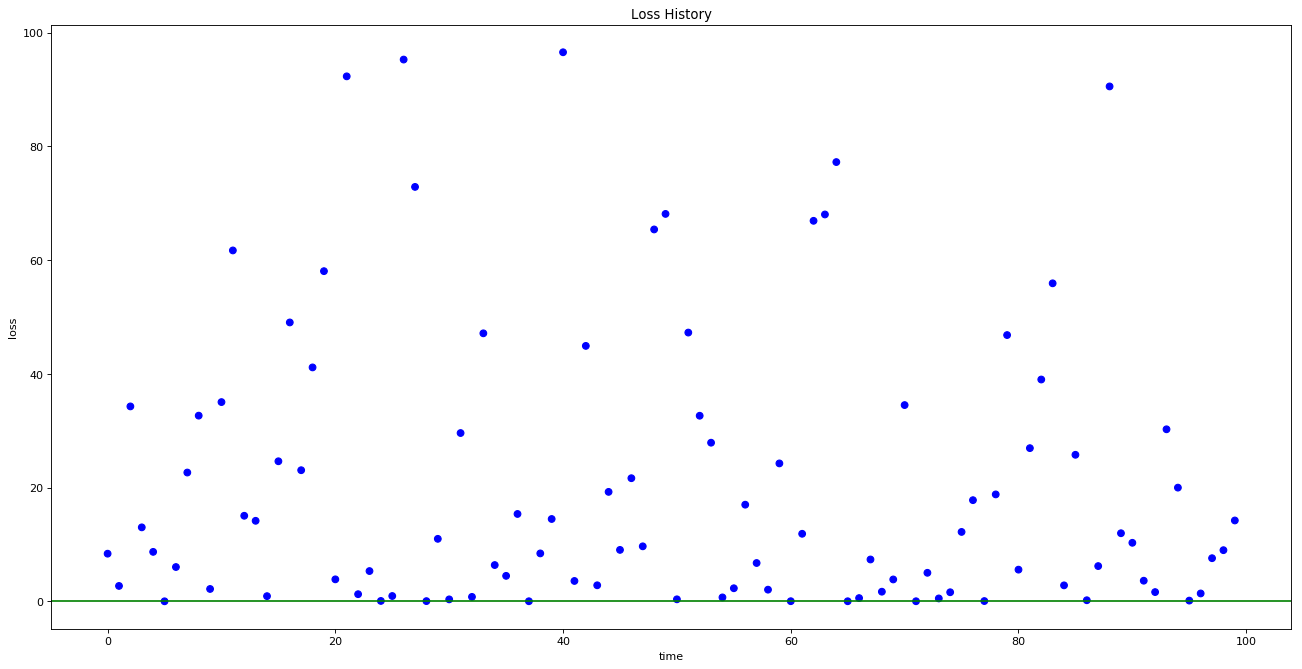

In [12]:


plt.figure(num=None, figsize=(20, 10), dpi=80)
main_plot_history(trials)

In [13]:
losses = [t['result']['loss'] for t in trials.trials]
range(len(losses))

range(0, 100)

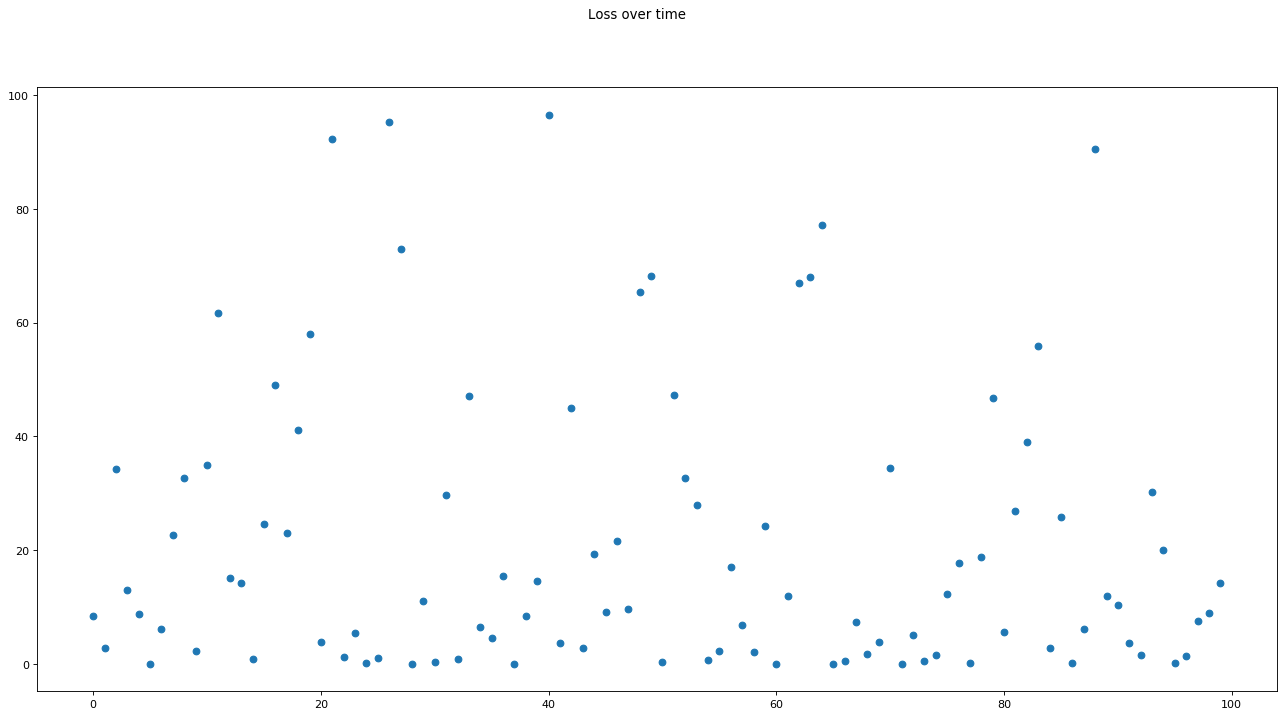

In [14]:
fig = plt.figure(num=None, figsize=(20, 10), dpi=80)
fig.suptitle('Loss over time')
plt.scatter(range(len(losses)), losses)
plt.show()

Showing Histogram of 100 jobs


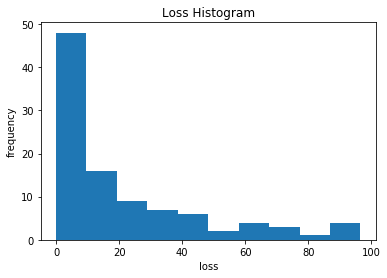

In [15]:
main_plot_histogram(trials)

In [16]:
figure(num=None, figsize=(20, 10), dpi=80)
main_plot_vars(trials)

NameError: name 'figure' is not defined